The exploratory analysis will be based on our goal and objectives.

**Primary goal**

The goal of this study is to analyze the impact of vaccination on community transmission and COVID-19 infections and deaths, using quantitative data from reliable datasets, and present findings to inform public health strategies.

**Objectives**

Analyze the Impact of Vaccination Status on Infection and Mortality Rates.

Assess the Influence of Community Transmission Levels.

Identify Geographic disparities.

Develop Data-Driven Public Health Recommendations.

In [1]:
import sqlite3
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from tabulate import tabulate

**CREATE THE DATABASE SQL_data.db**

In [2]:
# Print clean datasets' columns
clean = pd.read_csv("Data/clean/clean_data_1.csv")
clean.columns

Index(['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'],
      dtype='object')

In [3]:
clean = pd.read_csv("Data/clean/clean_data_2.csv")
clean.columns

Index(['state_name', 'date', 'community_transmission_level'], dtype='object')

In [4]:
# Name the tables
Covid_rates_columns = ['outcome', 'month', 'Age group', 'Vaccinated with outcome',
       'Unvaccinated with outcome'
    
]

trans_level_columns = ['state_name', 'date', 'community_transmission_level'
    
]

# Create empty DataFrames
Covid_rates = pd.DataFrame(columns=Covid_rates_columns)
trans_level = pd.DataFrame(columns=trans_level_columns)

# Load the CSV files into the DataFrames
Covid_rates = pd.read_csv("Data/clean/clean_data_1.csv")
trans_level = pd.read_csv("Data/clean/clean_data_2.csv")

# Define the file path for the SQLite database
db_path = "SQL_data.db"

# Create SQLite database and save tables
conn = sqlite3.connect("SQL_data.db")

# Save data into tables
Covid_rates.to_sql('Covid_rates', conn, index=False, if_exists='replace')
trans_level.to_sql('trans_level', conn, index=False, if_exists='replace')

print(f"Database created and loaded with data from CSV files at {db_path}")

Database created and loaded with data from CSV files at SQL_data.db


In [5]:
# fetch data from the tables
Covid_rates = pd.read_sql_query("SELECT * FROM Covid_rates LIMIT 5;", conn)
print("First 5 rows from Covid_rates table:")
print(Covid_rates)

trans_level = pd.read_sql_query("SELECT * FROM trans_level LIMIT 5;", conn)
print("First 5 rows from trans_level table:")
print(trans_level)

# Close the connection
conn.close()

First 5 rows from Covid_rates table:
  outcome     month Age group  Vaccinated with outcome  \
0    case  APR 2021     12-17                        8   
1    case  APR 2021     18-29                      674   
2    case  APR 2021     30-49                     1847   
3    case  APR 2021     50-64                     1558   
4    case  APR 2021     65-79                     1672   

   Unvaccinated with outcome  
0                      30785  
1                      76736  
2                      98436  
3                      50324  
4                      14880  
First 5 rows from trans_level table:
  state_name        date community_transmission_level
0      Texas  01/27/2020                         high
1   Nebraska  01/27/2020                         high
2   Illinois  01/27/2020                         high
3       Iowa  01/27/2020                         high
4  Tennessee  02/05/2020                          low


In [7]:
# Save the dabase in Data/ folder
source = "SQL_data.db"
destination = "Data/"
shutil.move(source, destination)

'Data/SQL_data.db'

**IMPACT OF VACCINATION ON INFECTIONS (CASES) BY AGE GROUP**

In [6]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

#Calculate age group using the sql
query = ("""

SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Cases,
    SUM(CASE WHEN outcome = 'case' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Cases
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Cases DESC;
""")

# Run the query and load results into a DataFrame
cases_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the result using tabulate
print(tabulate(cases_by_age_group, headers='keys', tablefmt='grid', showindex=False))

+--------------+--------------------+----------------------+---------------+
| Age group    |   Vaccinated_Cases |   Unvaccinated_Cases |   Total_Cases |
+==============+====================+======================+===============+
| all_ages_adj |           35736157 |             83788412 |     119524569 |
+--------------+--------------------+----------------------+---------------+
| 30-49        |            6037254 |              6934922 |      12972176 |
+--------------+--------------------+----------------------+---------------+
| 18-29        |            3235323 |              5060862 |       8296185 |
+--------------+--------------------+----------------------+---------------+
| 50-64        |            4071401 |              3246103 |       7317504 |
+--------------+--------------------+----------------------+---------------+
| 65-79        |            2336144 |              1365175 |       3701319 |
+--------------+--------------------+----------------------+---------------+

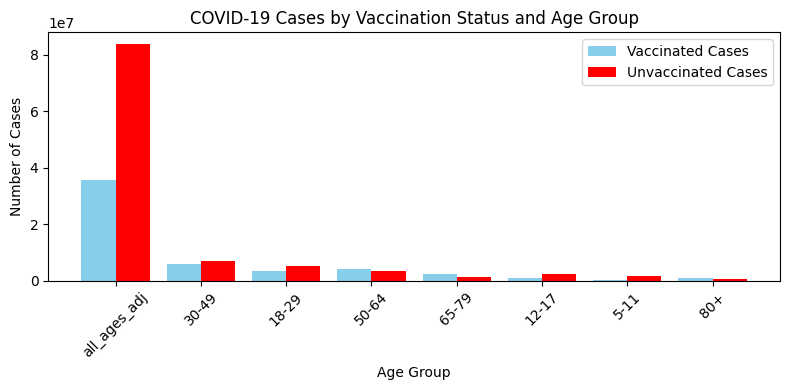

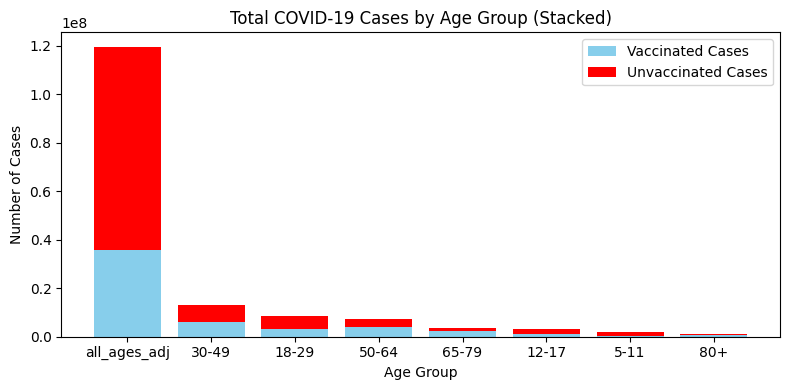

In [7]:
# Define Data for vizualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Cases": [35736157, 6037254, 3235323, 4071401, 2336144, 1064817, 374167, 758672],
    "Unvaccinated_Cases": [83788412, 6934922, 5060862, 3246103, 1365175, 2244912, 1687598, 407531],
    "Total_Cases": [119524569, 12972176, 8296185, 7317504, 3701319, 3309729, 2061765, 1166203],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Cases"], width=bar_width, label="Vaccinated Cases", color="skyblue")
plt.bar(x + bar_width/2, df["Unvaccinated_Cases"], width=bar_width, label="Unvaccinated Cases", color="red")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("COVID-19 Cases by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Cases"], label="Vaccinated Cases", color="skyblue")
plt.bar(df["Age group"], df["Unvaccinated_Cases"], bottom=df["Vaccinated_Cases"], label="Unvaccinated Cases", color="red")
plt.xlabel("Age Group")
plt.ylabel("Number of Cases")
plt.title("Total COVID-19 Cases by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

The bar chart, as well as the table, show the distribution of COVID-19 cases by age group and vaccination status. 
The "all ages-adj" category has a significantly higher number of unvaccinated cases (red) compared to vaccinated cases (blue), 
indicating that unvaccinated individuals contribute the most to the total case count. For specific age groups, the difference in cases 
between vaccinated and unvaccinated individuals is much smaller, suggesting that vaccination status may have a more noticeable impact 
in broader age groups, particularly in older populations.

The stacked bar chart shows that the majority of COVID-19 cases across all age groups are among unvaccinated individuals (red), with a smaller proportion of vaccinated individuals (blue), except in the "all ages-adj" category, where unvaccinated cases dominate significantly.

**Summery**: unvaccinated individuals are disproportionately contributing to COVID-19 case and death counts across all age groups. Unvaccinated individuals are more likely to become infected than those who are vaccinated. Younger, socially active groups contribute significantly to the case.

**IMPACT OF VACCINATION ON DEATHS BY AGE GROUP**

In [8]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')

# Calculate deaths by age group using SQL query
query = """
SELECT 
    [Age group], 
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] ELSE 0 END) AS Vaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Unvaccinated with outcome] ELSE 0 END) AS Unvaccinated_Deaths,
    SUM(CASE WHEN outcome = 'death' THEN [Vaccinated with outcome] + [Unvaccinated with outcome] ELSE 0 END) AS Total_Deaths
FROM Covid_rates
GROUP BY [Age group]
ORDER BY Total_Deaths ASC;
"""

# Execute the query and load results into a DataFrame
deaths_by_age_group = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the result using tabulate
print(tabulate(deaths_by_age_group, headers='keys', tablefmt='grid', showindex=False))

+--------------+---------------------+-----------------------+----------------+
| Age group    |   Vaccinated_Deaths |   Unvaccinated_Deaths |   Total_Deaths |
+==============+=====================+=======================+================+
| 5-11         |                   3 |                    46 |             49 |
+--------------+---------------------+-----------------------+----------------+
| 12-17        |                  27 |                   183 |            210 |
+--------------+---------------------+-----------------------+----------------+
| 18-29        |                 210 |                  2487 |           2697 |
+--------------+---------------------+-----------------------+----------------+
| 30-49        |                2277 |                 21013 |          23290 |
+--------------+---------------------+-----------------------+----------------+
| 50-64        |               10328 |                 49229 |          59557 |
+--------------+---------------------+--

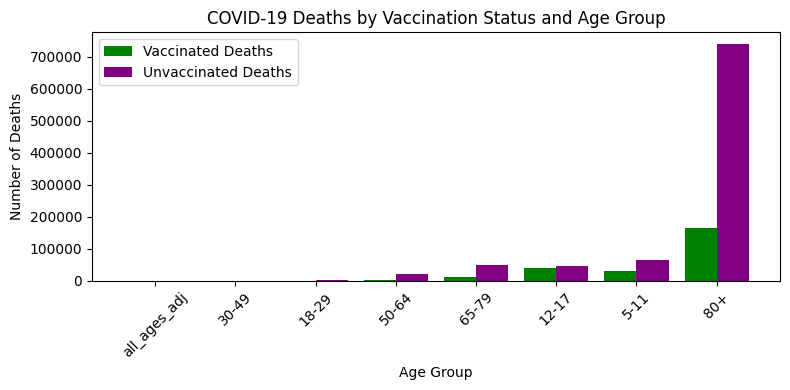

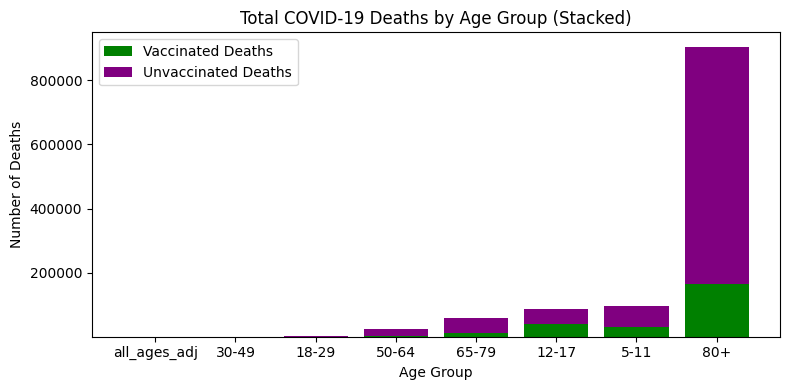

In [9]:
# Define Data for visualization
data = {
    "Age group": ["all_ages_adj", "30-49", "18-29", "50-64", "65-79", "12-17", "5-11", "80+"],
    "Vaccinated_Deaths": [3, 27, 210, 2277, 10328, 39438, 30248, 164958],
    "Unvaccinated_Deaths": [46, 183, 2487, 21013, 49229, 46355, 65686, 739996],
    "Total_Deaths": [49, 210, 2697, 23290, 59557, 85793, 95934, 904954],
}

df = pd.DataFrame(data)

# Set positions for bars
x = np.arange(len(df["Age group"]))

# Bar chart: Vaccinated vs. Unvaccinated Cases
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(x - bar_width/2, df["Vaccinated_Deaths"], width=bar_width, label="Vaccinated Deaths", color="green")
plt.bar(x + bar_width/2, df["Unvaccinated_Deaths"], width=bar_width, label="Unvaccinated Deaths", color="purple")
plt.xticks(x, df["Age group"], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("COVID-19 Deaths by Vaccination Status and Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked Bar Chart: Total Cases
plt.figure(figsize=(8, 4))
plt.bar(df["Age group"], df["Vaccinated_Deaths"], label="Vaccinated Deaths", color="green")
plt.bar(df["Age group"], df["Unvaccinated_Deaths"], bottom=df["Vaccinated_Deaths"], label="Unvaccinated Deaths", color="purple")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Total COVID-19 Deaths by Age Group (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()

There is a disparity between vaccinated and unvaccinated populations.
About 904954 deaths occurred across all age groups, with 82% (739996) among unvaccinated individuals.
The 65-79 and 80+ age groups were at the highest death tolls (95934 and 85793 deaths, respectively), likely driven by unvaccinated individuals.
Deaths among children and adolescents (5-11, and 12-17 years) were minimal, 259 deaths.

**Summery**, this result revel the importance of vaccination: deaths among vaccinated individuals were consistently lower across all age groups, 
reflecting vaccine effectiveness in reducing mortality.

**LEVEL OF TRANSMISSION BY SEASON AND STATE**

In [10]:
# Connect to the SQLite database
conn = sqlite3.connect('Data/SQL_data.db')
query = """
SELECT
    date,
    state_name,
    community_transmission_level
FROM
    trans_level;
"""

In [11]:
#Load the query into a Pandas DataFrame
df_transmission = pd.read_sql_query(query, conn)

In [12]:
#Close the database connection
conn.close()

In [13]:
#Convert 'date' column to datetime
df_transmission['date'] = pd.to_datetime(df_transmission['date'])

In [15]:
#Map the transmission level to numeric values and create numeric_level column
level_map = {'low': 1, 'moderate': 2, 'high': 3, 'substantial': 4}
df_transmission['numeric_level'] = df_transmission['community_transmission_level'].map(level_map)
print(df_transmission[['community_transmission_level', 'numeric_level']])    #.drop_duplicates())

        community_transmission_level  numeric_level
0                               high              3
1                               high              3
2                               high              3
3                               high              3
4                                low              1
...                              ...            ...
3225217                          low              1
3225218                          low              1
3225219                         high              3
3225220                  substantial              4
3225221                     moderate              2

[3225222 rows x 2 columns]


In [16]:
print(df_transmission)

              date    state_name community_transmission_level  numeric_level
0       2020-01-27         Texas                         high              3
1       2020-01-27      Nebraska                         high              3
2       2020-01-27      Illinois                         high              3
3       2020-01-27          Iowa                         high              3
4       2020-02-05     Tennessee                          low              1
...            ...           ...                          ...            ...
3225217 2022-10-18     Louisiana                          low              1
3225218 2022-10-18  South Dakota                          low              1
3225219 2022-10-18         Texas                         high              3
3225220 2022-10-18      Virginia                  substantial              4
3225221 2022-10-18       Wyoming                     moderate              2

[3225222 rows x 4 columns]


In [17]:
# Create a copy of the data and add seasons manually
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
df_seasons = pd.concat([
    df_transmission.assign(season=season) for season in seasons
])
print(df_seasons['season'].unique())

['Winter' 'Spring' 'Summer' 'Fall']


In [18]:
print(df_seasons)

              date    state_name community_transmission_level  numeric_level  \
0       2020-01-27         Texas                         high              3   
1       2020-01-27      Nebraska                         high              3   
2       2020-01-27      Illinois                         high              3   
3       2020-01-27          Iowa                         high              3   
4       2020-02-05     Tennessee                          low              1   
...            ...           ...                          ...            ...   
3225217 2022-10-18     Louisiana                          low              1   
3225218 2022-10-18  South Dakota                          low              1   
3225219 2022-10-18         Texas                         high              3   
3225220 2022-10-18      Virginia                  substantial              4   
3225221 2022-10-18       Wyoming                     moderate              2   

         season  
0        Winter  
1  

In [19]:
#Create the Pivot table with an aggregation for Heatmap
heatmap_data = df_seasons.pivot_table(index='state_name', columns='season', values='numeric_level', aggfunc='mean')
print(heatmap_data)

season                    Fall    Spring    Summer    Winter
state_name                                                  
Alabama               2.800751  2.800751  2.800751  2.800751
Alaska                2.434469  2.434469  2.434469  2.434469
Arizona               2.790400  2.790400  2.790400  2.790400
Arkansas              2.677427  2.677427  2.677427  2.677427
California            2.732922  2.732922  2.732922  2.732922
Colorado              2.571891  2.571891  2.571891  2.571891
Connecticut           2.802323  2.802323  2.802323  2.802323
Delaware              2.929667  2.929667  2.929667  2.929667
District of Columbia  3.008991  3.008991  3.008991  3.008991
Florida               2.806731  2.806731  2.806731  2.806731
Georgia               2.757044  2.757044  2.757044  2.757044
Hawaii                2.185215  2.185215  2.185215  2.185215
Idaho                 2.602295  2.602295  2.602295  2.602295
Illinois              2.741794  2.741794  2.741794  2.741794
Indiana               2.

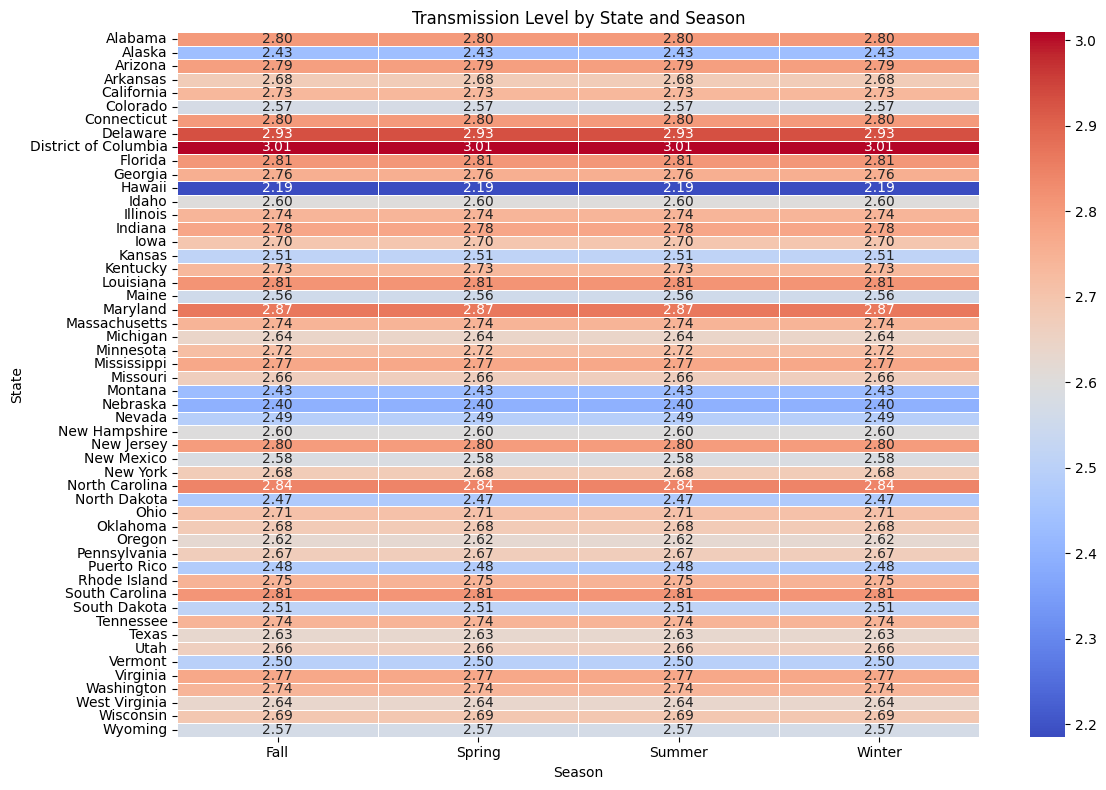

In [20]:
#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt='.2f',
    linewidths=0.5, cbar=True, cmap='coolwarm',
    xticklabels=True, yticklabels=True
    )
plt.title('Transmission Level by State and Season')
plt.xlabel('Season')
plt.ylabel('State')
plt.tight_layout()
plt.show()

The heatmap visualizes the average community transmission levels of COVID-19 across different U.S. states for all four seasons. 

***Color Scale***

Red Shades represent higher transmission levels, numeric value = 3.
Blue Shades represent lower transmission levels, numeric value = 1.

***Observations***

Most states maintained relatively high transmission levels across all seasons, indicated by the dominant red-orange shades.
States like District of Columbia, and Delaware exhibit consistently higher transmission levels across all seasons.
Hawaii and Nebraska show consistently lower transmission levels, blue shades.

Seasonal Trends: transmission levels appear to be relatively stable across seasons for most states, with no significant seasonal spikes or drops.
This suggests that transmission levels might not be heavily influenced by seasonal factors in this dataset, or it could indicate implementation of same public health measures across seasons.

***Insights and Recommendations***

States with high average levels, such as District of Columbia, and Delaware, might benefit from enhanced public health measures, such as vaccination drives, or public awareness campaigns.

Future Analysis: Incorporate factors like population density, vaccination rates, and public health policies to better understand why transmission levels vary across states.

**RELATIONSHIP BETWEEN TRANSMISSION LEVELS AND VACCINATION STATUS**

In [21]:
# CONNECT TO THE SQLite DATABASE AND FORMAT DATE IN 'month' COLUMN, table: Covid_rates

conn = sqlite3.connect('Data/SQL_data.db')

# Read the table from the database into a DataFrame
query = """
SELECT 
    month,  
    "Vaccinated with outcome", 
    "Unvaccinated with outcome" 
FROM 
   Covid_rates
"""
Covid_rates = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create a dictionary mapping abbreviated month names to month numbers
month_map = {
    'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUN': '06',
    'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
}

# Function to convert 'month' to 'mm/YYYY' format
def convert_month_format(month_str):
    month, year = month_str.split()
    return f"{month_map[month[:3].upper()]}/{year}"

# Apply the function to create a formatted date column
Covid_rates['date_formatted'] = Covid_rates['month'].apply(convert_month_format)

# View the updated DataFrame
print(Covid_rates)

         month  Vaccinated with outcome  Unvaccinated with outcome  \
0     APR 2021                        8                      30785   
1     APR 2021                      674                      76736   
2     APR 2021                     1847                      98436   
3     APR 2021                     1558                      50324   
4     APR 2021                     1672                      14880   
...        ...                      ...                        ...   
1586  AUG 2022                      328                        172   
1587  AUG 2022                      603                        398   
1588  AUG 2022                       33                        398   
1589  AUG 2022                      286                        398   
1590  AUG 2022                      280                        398   

     date_formatted  
0           04/2021  
1           04/2021  
2           04/2021  
3           04/2021  
4           04/2021  
...             ...  
1586 

In [22]:
# CONNECT TO SQLite DATABASE AND FORMAT DATE IN 'date' COLUMN, table: trans_level

# Path to the SQLite database
db_path = "Data/SQL_data.db"

conn = sqlite3.connect(db_path)

# Query to fetch the necessary data
query = """
SELECT
    date,
    community_transmission_level
FROM
    trans_level
"""

# Load the data into a DataFrame
trans_level = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert the 'date' column to datetime
trans_level['date'] = pd.to_datetime(trans_level['date'], format='%m/%d/%Y', errors='coerce')

# Filter rows for dates between 04/2021 and 08/2022
start_date = "04/2021"
end_date = "08/2022"
trans_level_filtered = trans_level[(trans_level['date'] >= start_date) & (trans_level['date'] <= end_date)]

# Create a 'date_formatted' column in 'MM/YYYY' format
trans_level_filtered['date'] = pd.to_datetime(trans_level['date'], format='%m/%d/%Y', errors='coerce')
trans_level_filtered['date_formatted'] = trans_level_filtered['date'].dt.strftime('%m/%Y')
print(trans_level_filtered.head())

          date community_transmission_level date_formatted
251 2021-04-08                          low        04/2021
252 2021-04-08                          low        04/2021
253 2021-04-08                         high        04/2021
254 2021-04-08                  substantial        04/2021
255 2021-04-08                          low        04/2021


C:\Users\weare\AppData\Local\Temp\ipykernel_3440\4271217627.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_level_filtered['date'] = pd.to_datetime(trans_level['date'], format='%m/%d/%Y', errors='coerce')
C:\Users\weare\AppData\Local\Temp\ipykernel_3440\4271217627.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_level_filtered['date_formatted'] = trans_level_filtered['date'].dt.strftime('%m/%Y')


In [23]:
# MERGE DATAFRAMES

#Format 'month' column in Covid_rates to 'date_formatted'
Covid_rates['month'] = pd.to_datetime(Covid_rates['month'], format='%B %Y', errors='coerce')
Covid_rates['date_formatted'] = Covid_rates['month'].dt.strftime('%m/%Y')

# Merge the DataFrames on 'date_formatted'
merged_df = pd.merge(trans_level_filtered, Covid_rates, on='date_formatted', how='left')
print(merged_df.head())

        date community_transmission_level date_formatted month  \
0 2021-04-08                          low        04/2021   NaT   
1 2021-04-08                          low        04/2021   NaT   
2 2021-04-08                         high        04/2021   NaT   
3 2021-04-08                  substantial        04/2021   NaT   
4 2021-04-08                          low        04/2021   NaT   

   Vaccinated with outcome  Unvaccinated with outcome  
0                      NaN                        NaN  
1                      NaN                        NaN  
2                      NaN                        NaN  
3                      NaN                        NaN  
4                      NaN                        NaN  


In [24]:
merged_df.dtypes

date                            datetime64[ns]
community_transmission_level            object
date_formatted                          object
month                           datetime64[ns]
Vaccinated with outcome                float64
Unvaccinated with outcome              float64
dtype: object

In [27]:
merged_df['Vaccinated with outcome'].mean()

np.float64(20541.22023809534)

In [28]:
# Replacing NAN by the mean value
merged_df['Vaccinated with outcome'] = merged_df['Vaccinated with outcome'].fillna(merged_df['Vaccinated with outcome'].mean())
print(merged_df.head())

        date community_transmission_level date_formatted month  \
0 2021-04-08                          low        04/2021   NaT   
1 2021-04-08                          low        04/2021   NaT   
2 2021-04-08                         high        04/2021   NaT   
3 2021-04-08                  substantial        04/2021   NaT   
4 2021-04-08                          low        04/2021   NaT   

   Vaccinated with outcome  Unvaccinated with outcome  
0             20541.220238                        NaN  
1             20541.220238                        NaN  
2             20541.220238                        NaN  
3             20541.220238                        NaN  
4             20541.220238                        NaN  


In [29]:
merged_df['Unvaccinated with outcome'].mean()

np.float64(29763.184523809523)

In [30]:
merged_df['Unvaccinated with outcome'] = merged_df['Unvaccinated with outcome'].fillna(merged_df['Unvaccinated with outcome'].mean())
print(merged_df.head())

        date community_transmission_level date_formatted month  \
0 2021-04-08                          low        04/2021   NaT   
1 2021-04-08                          low        04/2021   NaT   
2 2021-04-08                         high        04/2021   NaT   
3 2021-04-08                  substantial        04/2021   NaT   
4 2021-04-08                          low        04/2021   NaT   

   Vaccinated with outcome  Unvaccinated with outcome  
0             20541.220238               29763.184524  
1             20541.220238               29763.184524  
2             20541.220238               29763.184524  
3             20541.220238               29763.184524  
4             20541.220238               29763.184524  


In [31]:
# CREATE A CONTINGENCY TABLE

# Bin Unvaccinated and Vaccinated outcomes into high/low
merged_df['Unvaccinated_category'] = pd.cut(
    merged_df['Unvaccinated with outcome'], bins=[-np.inf, 50, np.inf], labels=['low', 'high']
)
merged_df['Vaccinated_category'] = pd.cut(
    merged_df['Vaccinated with outcome'], bins=[-np.inf, 50, np.inf], labels=['low', 'high']
)

# Contingency table
contingency_table = pd.crosstab(
    merged_df['community_transmission_level'],
    [merged_df['Unvaccinated_category'], merged_df['Vaccinated_category']]
)
print(contingency_table)

Unvaccinated_category             low           high         
Vaccinated_category               low   high     low     high
community_transmission_level                                 
high                          1143407  56175  663159  5865593
low                            243896   9120  260607  1282056
moderate                       610159  19095  806838  3312275
substantial                    499588  15492  666564  2698724


In [32]:
# RUN CHI-SQUARE TEST

stat, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {stat}, p-value: {p}, Degrees of Freedom: {dof}")

Chi-square Statistic: 266681.38377577206, p-value: 0.0, Degrees of Freedom: 9


Chi-square Statistic (stat) quantifies how much the observed data deviates from the expected data.

p-value:

If p < 0.05, the relationship between vaccination outcomes and community transmission levels is statistically significant. 
If p >= 0.05, there's no statistically significant relationship.
For this analysis p(0.0) < 0.05, meaning the relationship vaccination and transmission level is significant.

Degrees of Freedom indicates the number of categories contributing to the test.

Expected Frequencies: Compare the expected frequencies (calculated under the null hypothesis of no association) with the observed values
in the contingency table. Large disparities indicate stronger associations.

The contingency table shows how "Vaccinated with outcome" and "Unvaccinated with outcome" are distributed across different levels of transmission.

The expected frequency table shows what the counts would look like if there were no relationship between transmission level and vaccination status. 

The differences between observed and expected values, especially in high and substantial transmission levels, suggest a strong association 
between community transmission level and vaccination outcomes. Vaccinated individuals tend to have higher outcomes in areas with 
high transmission compared to unvaccinated individuals.

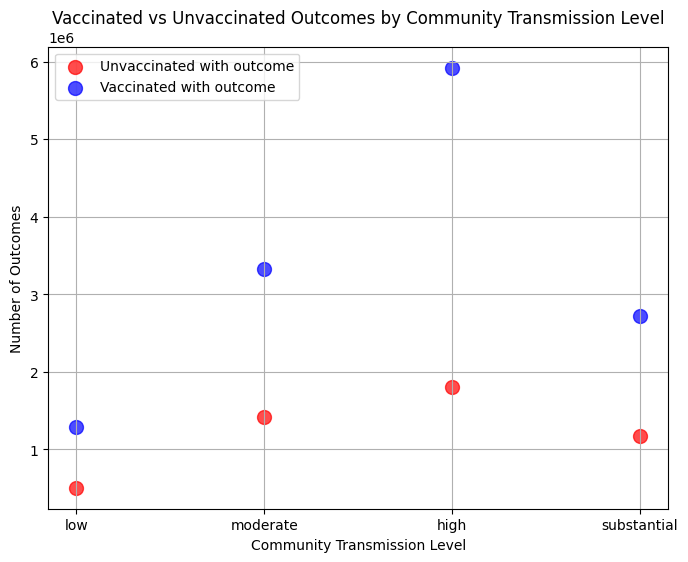

In [33]:
# CALCULATE TOTAL OUTCOMES FOR EACH GROUP AT EACH TRANSMISSION LEVEL AND PLOT A SCATTER PLOT.

unvaccinated_outcomes = [
    contingency_table.loc['low', ('low', 'low')] + contingency_table.loc['low', ('high', 'low')],
    contingency_table.loc['moderate', ('low', 'low')] + contingency_table.loc['moderate', ('high', 'low')],
    contingency_table.loc['high', ('low', 'low')] + contingency_table.loc['high', ('high', 'low')],
    contingency_table.loc['substantial', ('low', 'low')] + contingency_table.loc['substantial', ('high', 'low')]
]
vaccinated_outcomes = [
    contingency_table.loc['low', ('low', 'high')] + contingency_table.loc['low', ('high', 'high')],
    contingency_table.loc['moderate', ('low', 'high')] + contingency_table.loc['moderate', ('high', 'high')],
    contingency_table.loc['high', ('low', 'high')] + contingency_table.loc['high', ('high', 'high')],
    contingency_table.loc['substantial', ('low', 'high')] + contingency_table.loc['substantial', ('high', 'high')]
]

# Community transmission levels
community_levels = ['low', 'moderate', 'high', 'substantial']

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot for Unvaccinated with outcome
plt.scatter(community_levels, unvaccinated_outcomes, color='red', label='Unvaccinated with outcome', s=100, alpha=0.7)

# Scatter plot for Vaccinated with outcome
plt.scatter(community_levels, vaccinated_outcomes, color='blue', label='Vaccinated with outcome', s=100, alpha=0.7)

# Add labels and legend
plt.title("Vaccinated vs Unvaccinated Outcomes by Community Transmission Level")
plt.savefig("Vaccinated vs Unvaccinated Outcomes by Community Transmission Level.png") 
plt.xlabel("Community Transmission Level")
plt.ylabel("Number of Outcomes")
plt.legend()
plt.grid(True)

# Display plot
plt.show()

The scatter plot shows the number of outcomes for vaccinated and unvaccinated individuals at different levels of transmission. 

In all transmission levels, the number of outcomes is higher for vaccinated individuals (represented by the blue points) 
compared to unvaccinated individuals (represented by the red points). In this analysis, the "high" transmission level shows a contrast 
with much higher outcomes for vaccinated individuals. 

**COMMUNITY TRANSMISSION LEVEL BEFORE AND AFTER VACCINES WERE INTRODUCED**

In [27]:
db_path = "Data/SQL_data.db"

conn = sqlite3.connect(db_path)

In [29]:
query = """SELECT 
    CASE 
        WHEN date < '2020-12-14' THEN 'Before December 14, 2020'
        ELSE 'After December 14, 2020'
    END AS time_period,
    AVG(
        CASE 
            WHEN community_transmission_level = 'low' THEN 1
            WHEN community_transmission_level = 'moderate' THEN 2
            WHEN community_transmission_level = 'high' THEN 3
            WHEN community_transmission_level = 'substantial' THEN 4
            ELSE NULL  -- In case of any unexpected values
        END
    ) AS avg_transmission_level
FROM 
    trans_level
GROUP BY 
    time_period
"""

In [32]:
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the DataFrame
print(df)

                time_period  avg_transmission_level
0  Before December 14, 2020                2.673467


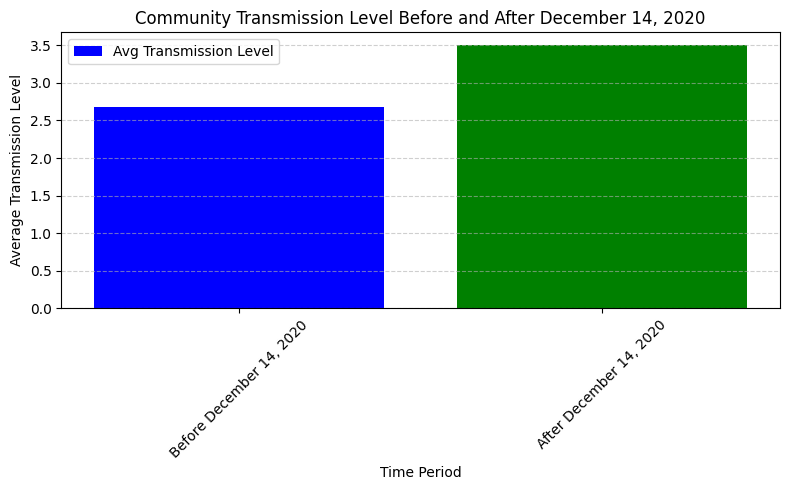

In [35]:
data = {
    'time_period': ['Before December 14, 2020', 'After December 14, 2020'],
    'avg_transmission_level': [2.673467, 3.5]  
}

df = pd.DataFrame(data)

# bar plot
plt.figure(figsize=(8, 5))
plt.bar(df['time_period'], df['avg_transmission_level'], color=['blue', 'green'], label='Avg Transmission Level')

# Labeling
plt.xlabel('Time Period')
plt.ylabel('Average Transmission Level')
plt.title('Community Transmission Level Before and After December 14, 2020')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')  
plt.xticks(rotation=45) 
plt.legend()

# Show plot
plt.tight_layout()
plt.show()